# parse fit file and smooth gps
* cordinates are in semicircles (s)
* normal units for pos is degrees (d)
* usfull to convert to distance/speed is radians (r)

$d=s*\frac{180}{2^{31}}$

$r=d*\frac{\pi}{180}$

* kalman filter can help smoothing track
    * does not work great - 
    * gps error is clearly not independent
    * potentially due to (kalman?) filter/ correction algorithm applied by the whatch
    * subsampling (eg at 30 seconds) improves performance
* which timepoints
    * fixed (e.g. every 30 seconds)
    * use gps quality
    * use magnetometer to detect turns / corrections of direction
    * use accelometer to detect turns / pauses ...
    * use button to mark turn
    



In [1]:

from fitparse import FitFile

from math import sqrt, pi, cos
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm, trange




#%matplotlib ipympl
R = 6371000 #earth radius [m]


In [44]:
#fitfile = FitFile('fit_files/2912551983.fit') #cycling (example with good gps)

#fitfile = FitFile('fit_files/2853423540.fit')#short swim
fitfile = FitFile('fit_files/2871238195.fit')#longer swim two way
fitfile = FitFile('fit_files/2913114523.fit')#krumme lanke swim



In [45]:
def toDegree(s): 
    s=np.array(s)
    d=s*180/2**31
    return d


def toDeltaMeter(lat_d, lng_d):
    R = 6371000 #earth radius [m]
    delta_lat_d=np.diff(lat_d)
    delta_lng_d=np.diff(lng_d)
    delta_lat_m=delta_lat_d * R * pi / 180
    delta_lng_m=delta_lng_d * R * pi / 180 * np.cos(np.array(lat_d[:-1])*pi/180)
    dist=np.sqrt(delta_lat_m**2+delta_lng_m**2)
    return(pd.DataFrame({'delta_lat': delta_lat_m,  'delta_lng': delta_lng_m, 'dist': dist}))
    
    

In [46]:
data={}
# Get all data messages that are of type record
for i, record in enumerate(fitfile.get_messages('record')):
    #print("{}___".format(i))
    # Go through all the data entries in this record
    fields=set(['position_lat_deg', 'position_long_deg', 'delta_lat','delta_long', 'delta' ])
    for record_data in record:
        # Print the records name and value (and units if it has any)
        fields.add(record_data.name)
        if i==0:
            if record_data.units:
                print (" * {}: {} {}".format(record_data.name, record_data.value, record_data.units))
            else:
                print (" * {}: {}".format(record_data.name, record_data.value))
        if record_data.name not in data:
            data[record_data.name]=[np.nan] * i
        data[record_data.name].append(record_data.value)
    for missing in set(data.keys()).difference(fields):
        data[missing].append(np.nan)
    lat_deg=data['position_lat'][-1]*180/2 ** 31
    long_deg=data['position_long'][-1]*180/2 ** 31    
    if i==0:
        data['position_lat_deg']=[lat_deg]
        data['position_long_deg']=[long_deg]
        data['delta_lat']=[0]
        data['delta_long']=[0]
        data['delta']=[0]
    else:
        data['delta_lat'].append(R * (lat_deg-data['position_lat_deg'][-1])*pi/180)
        data['delta_long'].append(R * cos(lat_deg*pi/180) * (long_deg-data['position_long_deg'][-1])*pi/180)
        data['position_lat_deg'].append(lat_deg)
        data['position_long_deg'].append(long_deg)
        data['delta'].append(sqrt(data['delta_lat'][-1]**2 + data['delta_long'][-1]**2))
        


 * accel_X: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) millig
 * accel_Y: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) millig
 * accel_Z: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) millig
 * altitude: 30.200000000000045 m
 * cadence: 0 rpm
 * distance: 0.0 m
 * enhanced_altitude: 30.200000000000045 m
 * enhanced_speed: 0.0 m/s
 * fractional_cadence: 0.0 rpm
 * gps_accuracy: None
 * gps_lat: None semicircles
 * gps_lng: None semicircles
 * gps_time: None
 * heart_rate: 93 bpm
 * mag_X: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) mG
 * mag_Y: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) mG
 * mag_Z: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) mG
 * position_lat: 625807621 semicircles
 * position_long: 157952138

In [47]:
lat_d=toDegree(data['position_lat'])
lng_d=toDegree(data['position_long'])

test=toDeltaMeter(lat_d,lng_d)
test.head()

,delta_lat,delta_lng,dist
0,-0.037281,0.085195,0.092995
1,0.270287,0.232866,0.356766
2,-0.158444,-3.231731,3.235613
3,0.046601,-0.414616,0.417226
4,-0.904064,-0.971223,1.326879


In [48]:
tab=pd.DataFrame.from_dict(data)
tab.head()

,accel_X,accel_Y,accel_Z,altitude,cadence,delta,delta_lat,delta_long,distance,enhanced_altitude,...,position_lat,position_lat_deg,position_long,position_long_deg,pressure,section,speed,timestamp,unknown_87,unknown_88
0,"(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...",30.2,0,0.000000,0.000000,0.000000,0.00,30.2,...,625807621.0,52.454589,157952138.0,13.239395,"(None, None, None, None, None, None, None, Non...",None,0.000,2018-08-07 11:43:17,0,100.0
1,"(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...",31.4,60,0.092995,-0.037281,0.085195,0.08,31.4,...,625807617.0,52.454588,157952153.0,13.239397,"(None, None, None, None, None, None, None, Non...",None,0.000,2018-08-07 11:43:18,0,100.0
2,"(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...",32.4,60,0.356766,0.270287,0.232866,0.30,32.4,...,625807646.0,52.454591,157952194.0,13.239400,"(None, None, None, None, None, None, None, Non...",None,0.000,2018-08-07 11:43:19,0,100.0
3,"(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...",-60.0,0,3.235613,-0.158444,-3.231731,3.83,-60.0,...,625807629.0,52.454590,157951625.0,13.239352,"(None, None, None, None, None, None, None, Non...",None,0.560,2018-08-07 11:43:29,0,100.0
4,"(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...","(None, None, None, None, None, None, None, Non...",-12.2,0,0.417226,0.046601,-0.414616,4.19,-12.2,...,625807634.0,52.454590,157951552.0,13.239346,"(None, None, None, None, None, None, None, Non...",None,0.523,2018-08-07 11:43:30,0,100.0


In [49]:

#tab.plot("delta", "speed")
#those are the same:
#x.plot("enhanced_speed", "speed")
#x.plot("enhanced_altitude", "altitude")
start_lat=data['position_lat_deg'][0]
start_lng=data['position_long_deg'][0]
end_lat=data['position_lat_deg'][-1]
end_lng=data['position_long_deg'][-1]

def get_dist(start_lat, start_lng, end_lat, end_lng, method="euclid"):
    total_delta_lat=R * (start_lat-end_lat)*pi/180
    total_delta_long=R * cos(start_lat)*(start_lng-end_lng)*pi/180
    if method == "euclid":
        return sqrt(total_delta_lat**2 + total_delta_long**2)
    elif method =="manhatten":
        return abs(total_delta_lat) + abs(total_delta_long)

dists=[get_dist(start_lat,start_lng, data['position_lat_deg'][i],data['position_long_deg'][i]) for i in range(len(data['position_long_deg']))]
i_turn=np.nanargmax(dists)
dist_back=get_dist(start_lat,start_lng, data['position_lat_deg'][i_turn],data['position_long_deg'][i_turn])+get_dist(data['position_lat_deg'][i_turn],data['position_long_deg'][i_turn], end_lat, end_lng)
[np.sum(tab.speed),np.sum(tab.delta), data['distance'][-1], get_dist(start_lat,start_lng,end_lat,end_lng), dist_back]



[1262.705, 1610.4047395502869, 1212.25, 27.11521859818238, 647.8693283741528]

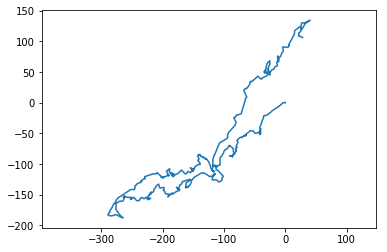

In [73]:
plt.axis('equal')
plt.plot(  np.nancumsum(tab.delta_long), np.nancumsum(tab.delta_lat))
plt.show()
#tab.to_csv('fit_files/processed.csv')

![](fit_files/swimtrack_unfiltered.png)

# Kalman Filtering
http://www.cbcity.de/das-kalman-filter-einfach-erklaert-teil-2


In [75]:
kalman_lat=kalman_lng=kalman_gain=var=[]
#x_hat[k|k]=x_fit=(lat_fit,lat_speed_fit, lng_fit, lng_speed_fit) in meters 
#x_hat[k|k-1]=x_pred=(lat_pred,lat_speed_fit, lng_pred, lng_speed_fit) in meters        
#z=(lat_gps, lng_gps) in meters
#R=[[sigma_gps^2,0],[0,sigma_gps^2]]
#time step=dt
#F=[[1,dt,0,0][0,1,0,0][0,0,1,dt][0,0,0,1]]
#H=[[1,0,0,0][0,0,1,0]]
#sigma_lat_speed
#sigma_lng_speed
#Q=[[sigma_gps^2,sigma_gps*sigma_lat_speed,0,0],
#   [0,sigma_lat_speed^2,0,0],
#   [0,0,sigma_lat_speed*sigma_gps,sigma_gps^2],
#   [0,0,0,sigma_lat_speed^2]]
#y_pred=z-Hx Innovation covar/pre fit residual
#y_fit=z-Hx_fit Innovation covar/post fit residual
col_names=["dt","lat_gps", "lng_gps", "speed_gps", "lat_fit", "lng_fit", "speed_fit", "estimated accuracy","kalman gain" ]
track=pd.DataFrame(columns=col_names)

step=10

for row in tab[1::step].itertuples():
    i=row.Index
    gps_lat=toDegree(row.position_lat)
    gps_lng=toDegree(row.position_long)
    if not np.isnan(gps_lat) and not np.isnan(gps_lng):

        if track.shape[0] == 0:
            #initialize:        
            z_lat=0
            z_lng=0
            lat_fit=0
            lng_fit=0
            lat_speed_fit=0
            lng_speed_fit=0
            sigma_gps=1 #estimated gps accuracy (= standard deviation in meter?)
            z_dist=0
            dist_fit=0
            dt=1
            p_fit=2**2
            k=1
        else:
            dt= (row.timestamp - prev_time).total_seconds() 

            #gps position in meter
            delta_z=toDeltaMeter([gps_lat_prev,gps_lat],[gps_lng_prev,gps_lng])
            z_dist=delta_z.dist[0]
            z_lat+=delta_z.delta_lat[0]
            z_lng+=delta_z.delta_lng[0]

            #estimated accuracy
            #sigma_gps=min(1,z_dist/dt)
            sigma_gps=abs(z_dist/dt-1)+1
            r=sigma_gps**2 #R
            q_pos=(.1*dt)**2       #may depend on swimming phase? e.g. turn
            
            #q_speed=(2*dt**2)**2

            #predict position: may depend on swimming phase? e.g. turn
            lat_pred=lat_fit+lat_speed_fit*dt
            lng_pred=lng_fit+lng_speed_fit*dt
            #prediction error covariance (P_k|k-1): 
            p_pred=p_fit+q_pos
            #p_speed_pred=p_speed_fit+q_speed

            #innovation y (pre-fit residuals)
            y_lat=z_lat-lat_pred
            y_lng=z_lng-lng_pred
            #innovation covariance S
            s=r+p_pred
            #kalman gain= prediction error covariance/innovation covariance
            k = p_pred/s
            #apply k
            lat_fit=lat_pred+y_lat*k
            lng_fit=lng_pred+y_lng*k
            lat_speed_fit=(lat_fit-lat_fit_prev)/dt
            lng_speed_fit=(lng_fit-lng_fit_prev)/dt        
            p_fit=(1-k)*p_pred+k*r
            dist_fit=sqrt((lat_speed_fit*dt)**2+(lng_speed_fit*dt)**2)

        df=pd.DataFrame([[dt, z_lat, z_lng,z_dist/dt, lat_fit, lng_fit, dist_fit/dt, p_fit,k]],columns=col_names)
        track=track.append(df, ignore_index=True)
        lat_fit_prev=lat_fit
        lng_fit_prev=lng_fit    
        gps_lat_prev=gps_lat
        gps_lng_prev=gps_lng       
        prev_time=row.timestamp

        
    track.to_csv('fit_files/kalman.csv')


/pkg/python-3.6.4-2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


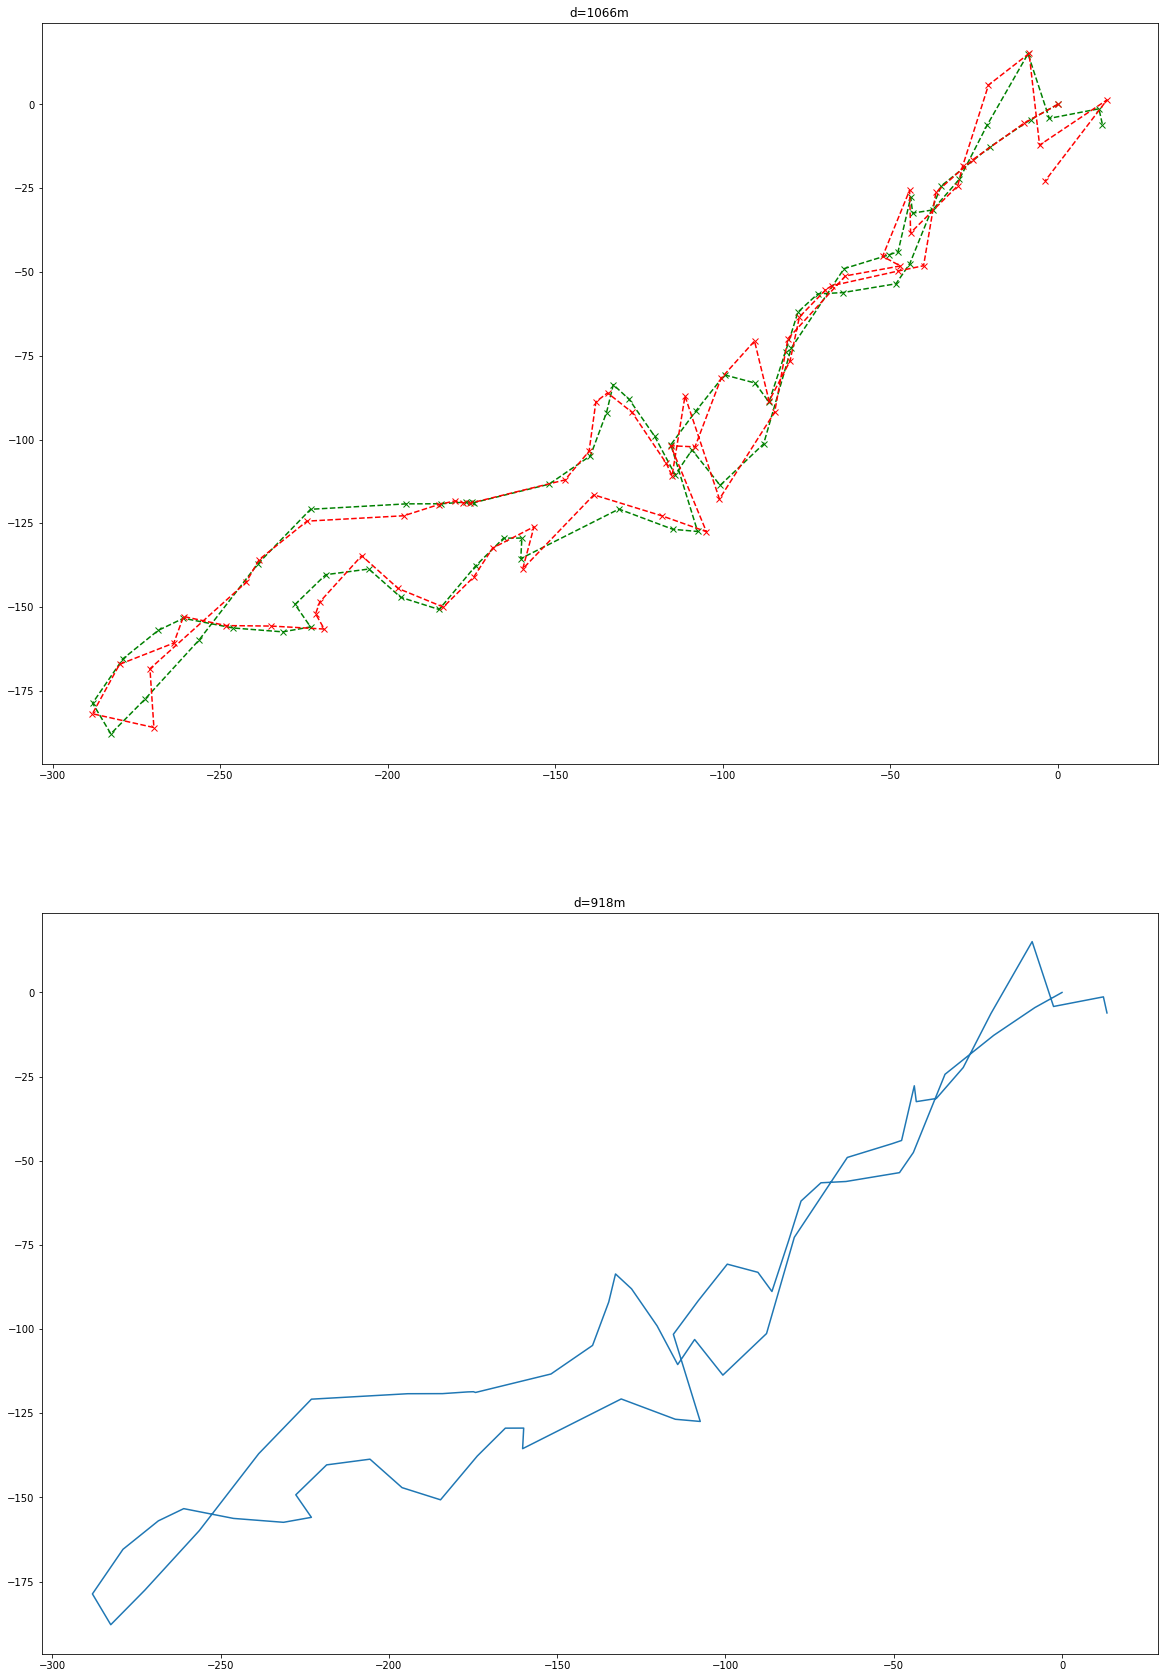

In [76]:
plt.axis('equal')
#import gtk

lim=(50,0,-10,200)

step=1

ax = plt.subplot(2, 1, 1)
ax.plot(track.lng_fit[0::step], track.lat_fit[0::step], "gx--")
ax.plot(track.lng_gps[0::step], track.lat_gps[0::step], "rx--")

dist=(track.lng_gps[0::step].diff().pow(2)+track.lat_gps[0::step].diff().pow(2)).pow(1/2).sum()
ax.set_title("d={}m".format(round(dist)))
#ax.axis(lim)
#ax.figure.set_size_inches(4,2)
ax.axis('equal')
ax = plt.subplot(2, 1, 2)
ax.plot(track.lng_fit[0::step], track.lat_fit[0::step])
dist=(track.lng_fit[0::step].diff().pow(2)+track.lat_fit[0::step].diff().pow(2)).pow(1/2).sum()
ax.set_title("d={}m".format(round(dist)))
ax = plt.subplot(2, 1, 2)
#ax.axis(lim)
ax.figure.set_size_inches(20,30)
ax.axis('equal')

plt.savefig('fit_files/filter.pdf')

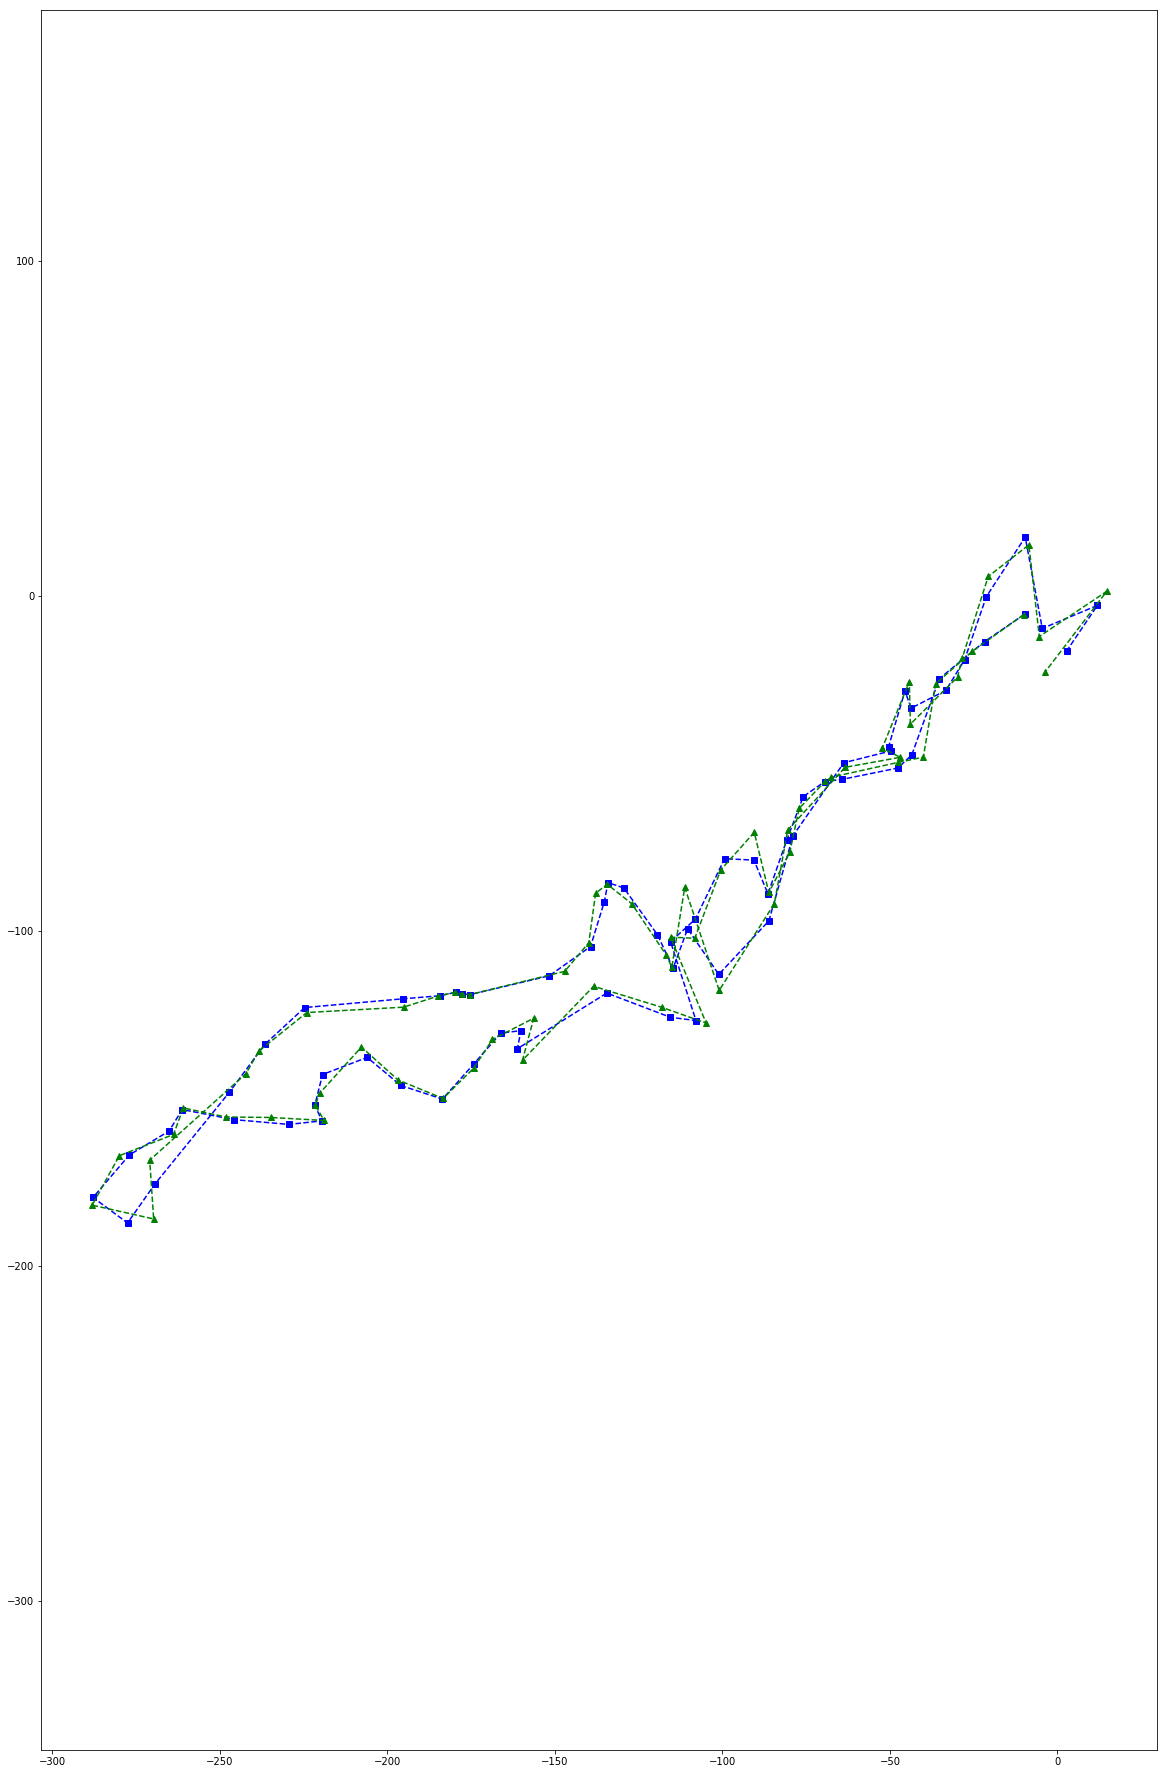

In [72]:
# red dashes, blue squares and green triangles
#plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
fig=plt.subplot(1,1,1)
#sel=(100,200)
sel=(1,100)
fig.plot(track.lng_fit[sel[0]:sel[1]], track.lat_fit[sel[0]:sel[1]], 'bs--',track.lng_gps[sel[0]:sel[1]], track.lat_gps[sel[0]:sel[1]], "g^--" )
fig.figure.set_size_inches(20,32)
fig.axis('equal')

plt.savefig('fit_files/filter_ol.pdf')


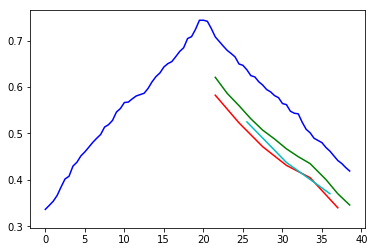

In [43]:
def runningMean(x, N):
    return np.convolve(x, np.ones((N,))/N, 'same')
time=np.cumsum(track.dt)/60
N=min(100,time.shape[0])
speed1=runningMean(track.speed_gps, N)
plt.plot(time, speed1,"b")

col=['g', 'r', 'c', 'm', 'y', 'k', 'tab:orange']
for i,step in enumerate([3,6,10,30,60,120,240]):
    speed=(track.lng_gps[0::step].diff().pow(2)+track.lat_gps[0::step].diff().pow(2)).pow(1/2)/(time[0::step].diff()*60)
    N=min(round(240/step)*2+1, speed.shape[0])
    speed=runningMean(speed, N)
    plt.plot(time[0::step],speed,col[i])
    

In [39]:
plt.plot(runningMeanFast(track.speed_fit, 100))

NameError: name 'runningMeanFast' is not defined

In [ ]:
fig=plt.subplot(1,1,1)
fig.plot(track.speed_gps, [sqrt(track["estimated accuracy"][i]) for i in range(track.shape[0])], "b^")
fig.figure.set_size_inches(16,16)
fig.axis((0,7,0,7))
